In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
scans = pd.read_csv('/home/brian/car/cpp/lidar/recording.csv');
scans['radians'] = scans.degrees * math.pi/180.
scans['x_meters'] = scans.distance_meters*np.cos(scans.radians)
scans['y_meters'] = scans.distance_meters*np.sin(scans.radians)

In [3]:
first_scan = min(scans.scan_number)
last_scan = max(scans.scan_number)

In [4]:
def get_scan(scan_number):
    s = scans[scans.scan_number == scan_number]
    return s
scan1 = get_scan(first_scan)

In [5]:

scan1.describe()

,scan_number,degrees,distance_meters,signal_strength,radians,x_meters,y_meters
count,360.0,360.000000,230.000000,230.000000,360.000000,230.000000,230.000000
mean,114.0,179.500000,0.732452,402.656522,3.132866,-0.190841,0.219564
std,0.0,104.067286,0.329617,238.445620,1.816317,0.516422,0.543863
min,114.0,0.000000,0.180000,10.000000,0.000000,-0.919933,-0.528491
25%,114.0,89.750000,0.574500,273.250000,1.566433,-0.594265,-0.195571
50%,114.0,179.500000,0.763000,368.500000,3.132866,-0.264824,-0.020958
75%,114.0,269.250000,0.867000,458.250000,4.699299,0.075357,0.612481
max,114.0,359.000000,1.774000,1870.000000,6.265732,1.217000,1.687174


In [7]:
def normalize(h):
    return (float(h[0])/float(h[2]),float(h[1])/float(h[2]),1.)


In [8]:
def distance_point_to_line(p,l):
    return np.abs(np.dot(normalize(l),normalize(p)))

In [9]:
# returns true if array x has nulls
def has_nulls(x):
    x = np.array(x)
    return not np.all(np.isnan(x)==False)

In [10]:
# takes vectors of X and Y for points along the line
#
# Finds the best fit line in the form ax + by + c = 0
# returns a,b,c (which is homogeneous coordinates for the line
def fit_line(x,y):
    A = np.array([x,y,np.ones_like(x)]).T
    U, S, V = np.linalg.svd(A)
    return V[2,:]

In [11]:
# returns true if all points in x,y are along the same line
# Homeogeneous math here:
#    http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/BEARDSLEY/node2.html
def is_line(x,y,tolerance):
    x=np.array(x)
    y=np.array(y)
    
    if has_nulls(x) or has_nulls(y): 
        return False
    
    # make homogeneous points out of x and y vectors
    points = [(x[i],y[i],1.) for i in range(len(x))]
    line = np.cross(points[0],points[-1])
    for p in points:
        d = distance_point_to_line(p,line)
        if d > tolerance:
            return False
    return True

    

In [12]:
v =  np.array([1,4,3])
np.all(np.isnan(v) == False)

True

In [13]:
x=[1 ,np.nan, 3]
y=[1, 1.1, 1]
is_line(x, y, tolerance=0.2)

False

In [14]:
# returns tuples of indexes of endpoints of all lines
# start at an index
# go ccw while still a line
# go cw while still a line
def find_lines(x,y,tolerance):
    found_lines = []
    start = 0
    while start < len(x):
        line_end = None
        for end in range(start+5, len(x)):
            if is_line(x[start:end],y[start:end],tolerance):
                line_end = end
            else:
                break
        if line_end is not None:
            found_lines.append((start,line_end))
            start = line_end + 1
        else:
            start += 1
    return found_lines

print(find_lines(scan1.x_meters, scan1.y_meters,tolerance=0.02))



[(72, 175), (176, 213), (216, 223), (224, 232), (233, 245), (286, 292), (293, 300), (339, 351), (352, 358)]


In [15]:
def line_y_for_x(l,x):
    # ax+by+c=0
    # y=(-c-ax)/b
    a,b,c = l
    return (-c-a*x)/b

In [16]:
def plot_scan(scan):
    plt.axis('equal')
    plt.plot(scan.x_meters,scan.y_meters,color="0.75",marker='.') # c=cyan
    plt.plot(0,0,'go')
    colors = ['r','g','k']
    for i,line in enumerate(find_lines(scan.x_meters, scan.y_meters,tolerance=0.03)):
        line_x = scan.x_meters[line[0]:line[1]]
        line_y = scan.y_meters[line[0]:line[1]]
        fit_l = fit_line(line_x,line_y)
        fit_x = line_x
        fit_y = [line_y_for_x(fit_l,px) for px in line_x]

        plt.plot(fit_x,
                 fit_y, 
                 colors[i%len(colors)])

In [17]:
min(scans.scan_number)

114

In [18]:
max(scans.scan_number)

161

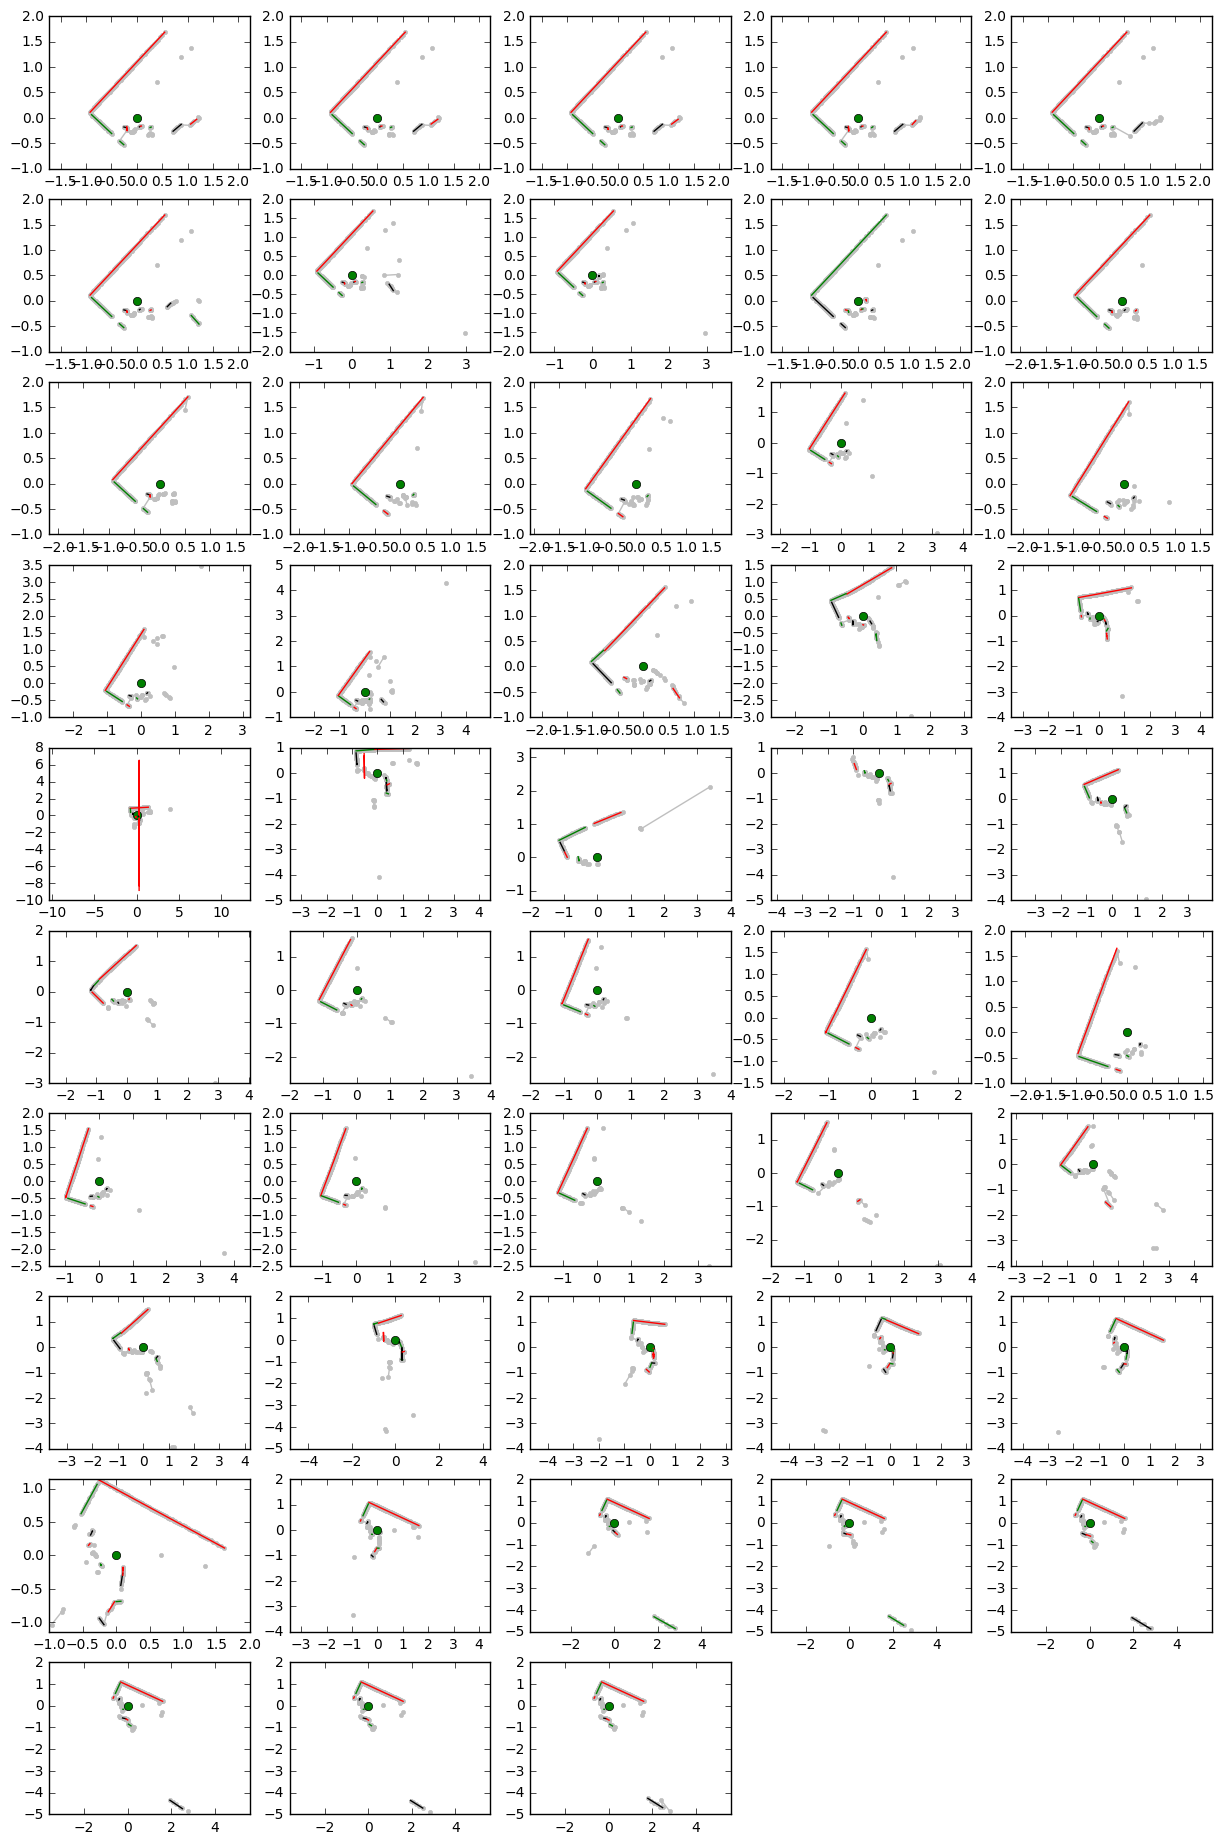

In [19]:
fig=plt.figure()
fig.set_size_inches(15,35)
for i,scan_number in enumerate(range(first_scan,last_scan+1)):
    plt.subplot(15,5,i+1)
    plot_scan(get_scan(scan_number))

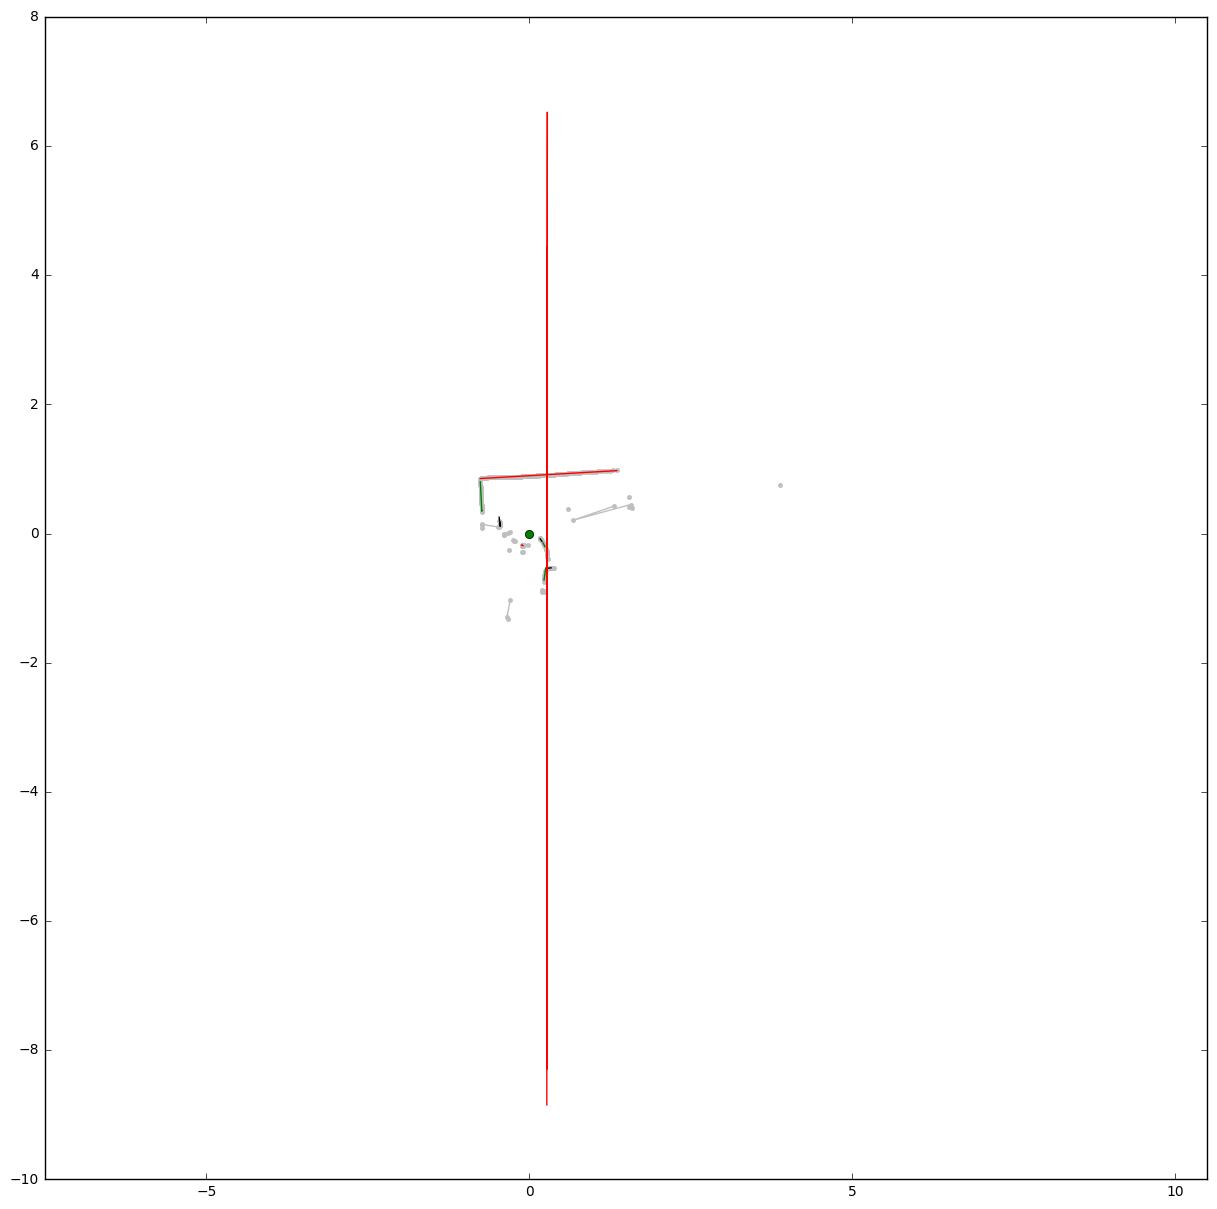

In [20]:
plt.figure().set_size_inches(15,15)
plot_scan(get_scan(first_scan+20))

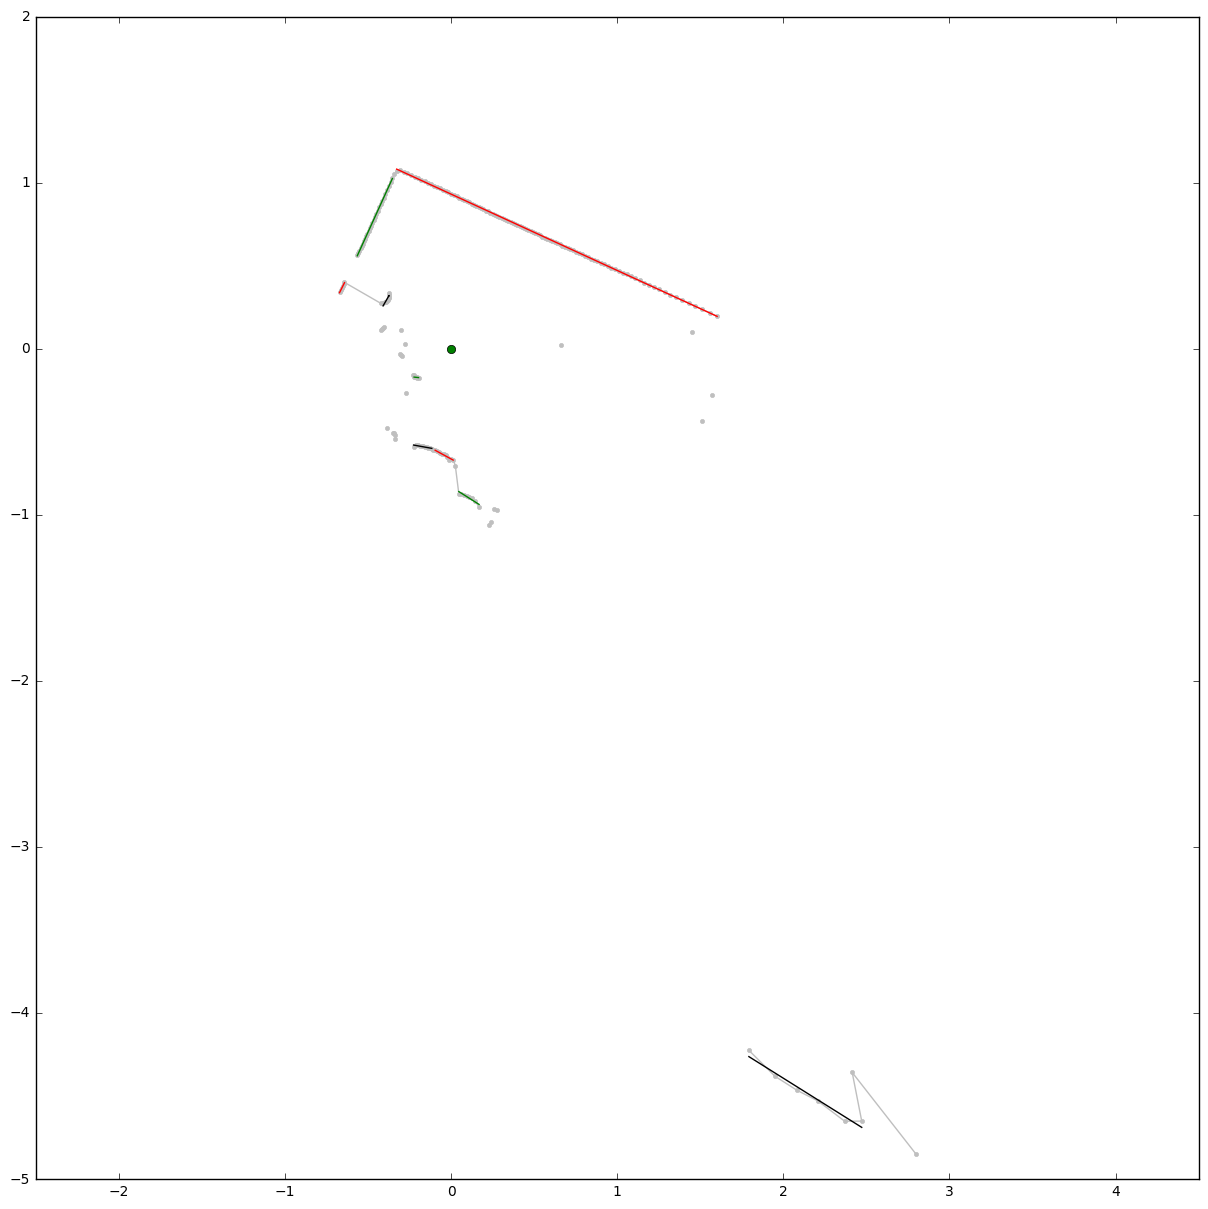

In [21]:
plt.figure().set_size_inches(15,15)
plot_scan(get_scan(last_scan))

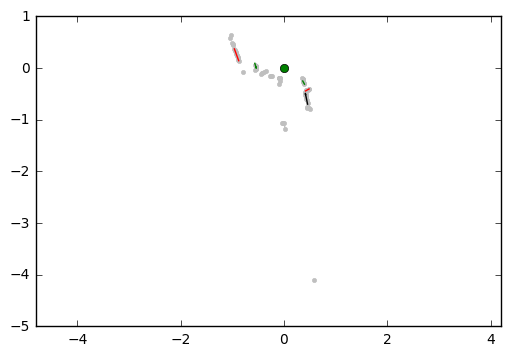

In [22]:
plot_scan(get_scan((first_scan+last_scan)//2))